<a href="https://colab.research.google.com/github/ipavlopoulos/paremia/blob/main/exploratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory analysis of Greek proverbs

* Using a collection of proverbs from the [Hellenic Folklore Research Centre](http://www.kentrolaografias.gr/) of the Academy of Athens
* Using [Folium](https://pypi.org/project/folium/) and [Geopy](https://geopy.readthedocs.io/en/stable/)

---


In [1]:
%%capture
!pip install geopandas
!pip install geopy
!pip install folium
!pip install gdown
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import folium
from tqdm.notebook import tqdm
from folium import Choropleth, Circle, CircleMarker, Marker
from folium.plugins import MarkerCluster
import matplotlib.pyplot as plt
import os

## Data loading

In [2]:
proverbs = pd.read_csv('data/proverbs.csv', index_col=0)
proverbs.shape

(134493, 4)

In [3]:
proverbs.sample(10)

,text,place,uri,collector
24453,Ο λωλός λουλούδια θέλει,Αμοργός,http://hdl.handle.net/20.500.11853/277161,"Ιωαννίδης, Εμμανουήλ"
25932,"Σαν θωρής βοριάν κι αστράφτει, κάτεχε χειμώνας...",Αμοργός,http://hdl.handle.net/20.500.11853/143368,"Ιωαννίδης, Εμμανουήλ"
68900,Αυτός είνι σα νύφ' τ' διφτέρα,Αιτωλία,http://hdl.handle.net/20.500.11853/287774,"Λουκόπουλος, Δημήτριος"
76538,Ηύρες άμμο κι΄ εκυλίστης κι' ηύγες όξω κι' εκα...,Κάρπαθος,http://hdl.handle.net/20.500.11853/153351,"Μανωλακάκης, Παπαγιάννης"
61172,Να σου δείξω (ε)γώ πόσ' απίδια βάζει ο σάκκος ...,Ρόδος,http://hdl.handle.net/20.500.11853/264573,"Κωνσταντινίδης, Θεόδωρος"
91759,Βαρύς κι ασήκωτος,Δαρδανέλλια (Ελλήσποντος),http://hdl.handle.net/20.500.11853/155882,"Οικονομίδης, Απόστολος Β."
126672,Άλλα στα χείλη κι' άλλα στην καρδιά,Σάμος,http://hdl.handle.net/20.500.11853/227618,anonymous
126323,"Αν πέση τ' αξινάρι στον ποταμό, μας μένει το σ...",Άδηλου τόπου,http://hdl.handle.net/20.500.11853/242066,anonymous
40600,Τώρα κι' αποσπείραμε!,"Αρκαδία, Γορτυνία",http://hdl.handle.net/20.500.11853/147142,"Κανδηλώρος, Τάκης Χ."
47790,"Ένας γιατρός, γιατρεύει χίλιους, χίλιοι δε για...","Αχαΐα, Πάτρα",http://hdl.handle.net/20.500.11853/180059,"Κορύλλος, Χρήστος Π."


In [4]:
# removing noisy input (e.g., definitions)
proverbs[proverbs.text.str.contains("=")].sample().text.item()

'Αγγελομαχώ = ψυχομαχώ, ψυχορραγώ'

In [5]:
proverbs = proverbs[~proverbs.text.str.contains("=")]
proverbs.shape

(134106, 4)

* Duplicates exist.

* Exact duplicates may be due to error.

* But there are also duplicated texts, meaning proverbs collected in different places.

In [6]:
# exact duplicates
print(proverbs.duplicated().sum())
proverbs[proverbs.duplicated()].sample()

13875


,text,place,uri,collector
123082,Αλιά απ΄ δεν τόχ΄ ου κούπερνας να κατεβάζ΄ ψείρες,Σκόπελος,http://hdl.handle.net/20.500.11853/170825,anonymous


In [7]:
# text duplicates
print(proverbs.text.duplicated().sum())
proverbs[proverbs.text.duplicated()].sample(10)

24836


,text,place,uri,collector
52146,Την έπαθε σαν αγράμματος,"Αχαΐα, Πάτρα",http://hdl.handle.net/20.500.11853/290600,"Κορύλλος, Χρήστος Π."
46079,Αέρας και γυναίκα δεν κλειδώνονται,"Αχαΐα, Πάτρα",http://hdl.handle.net/20.500.11853/179736,"Κορύλλος, Χρήστος Π."
130719,Άλλοι ψυχομαχούν κι' άλλοι καυλομαχούν,Κύπρος,http://hdl.handle.net/20.500.11853/159739,anonymous
121235,Αν είσαι και παπάς με την αράδα θα πας,Άδηλου τόπου,http://hdl.handle.net/20.500.11853/160083,anonymous
92157,Κώλος κλασμένος γιατρός χεσμένος,"Βόρειος Ήπειρος, Ντερβιτσάνη Αργυροκάστρου",http://hdl.handle.net/20.500.11853/178867,"Οικονομίδης, Δημήτριος"
125686,Άλλης Κυριακής ανάγνωσμα,Κρήτη,http://hdl.handle.net/20.500.11853/159900,anonymous
134009,"Αϊ Γιώργην όσον και να ξεπέφτει, πέντ' έξι άγι...","Πόντος, Οινόη",http://hdl.handle.net/20.500.11853/231843,anonymous
122643,"Άλλ' αντ' άλλα βλάβουν, τση Σατακουστής του γά...",Ήπειρος,http://hdl.handle.net/20.500.11853/159874,anonymous
89801,Ως πρόβατον επί σφαγήν,Λακωνία,http://hdl.handle.net/20.500.11853/261263,"Νεστορίδης, Κ."
90609,Αηλί π' κακουνταίσ',"Ιωάννινα, Νεγάδες",http://hdl.handle.net/20.500.11853/269039,"Οικονόμου, Μάνθος Κ."


* Places follow the pattern `area, locus, locus, ...`; where each `locus` is a more precisely located place.

* Having a comma inside the pattern can confuse output (for humans)  in pandas when sets are output as strings.

* So we'll substitute `,` by `>`.

In [8]:
proverbs.place = proverbs.place.str.replace('\s*,\s*', '>', regex=True)
proverbs.place

0             Κρήτη>Λασίθι>Κεντρί
1             Κρήτη>Λασίθι>Κεντρί
2             Κρήτη>Λασίθι>Κεντρί
3             Κρήτη>Λασίθι>Κεντρί
4         Κρήτη>Λασίθι>Τουρτούλοι
                   ...           
134488             Θράκη>Σαμακόβι
134489          Μεσσηνία>Φιλιατρά
134490                     Σίφνος
134491                    Ήπειρος
134492               Ηλεία>Πύργος
Name: place, Length: 134106, dtype: object

* Climbing up to the highest-level information per location labelled.

* In `'Κρήτη>Λασίθι>Κεντρί'`, for example, we only keep the first part of the term, using `split` to tokenise.

In [9]:
proverbs["area"] = proverbs.place.map(lambda x: x.split(">")[0])
proverbs.sample(10)

,text,place,uri,collector,area
7420,Κείνος που 'χει τα γέννια έχει και τα χτένια,Ρόδος,http://hdl.handle.net/20.500.11853/185313,"Βρόντης, Αναστάσιος",Ρόδος
5937,Πιάσαμε τα λόγια κι έγινε η τρυφτή όλο βόλια,Μικρά Ασία>Χιλή,http://hdl.handle.net/20.500.11853/202205,"Βλάχος, Σπ. Δ.",Μικρά Ασία
49095,Κάμε με παπά κι΄απόλαμε στο λόγγο!,Αχαΐα>Πάτρα,http://hdl.handle.net/20.500.11853/253761,"Κορύλλος, Χρήστος Π.",Αχαΐα
1076,"Με τα λόγια τα δικά σου, αναπαύκεις τηγ καρκιά...",Κύπρος,http://hdl.handle.net/20.500.11853/209329,"Αναγνωστόπουλος, Γ.",Κύπρος
84525,Θα μου (του) ξουρίσ΄ τ΄ αρχίδια,Λακωνία,http://hdl.handle.net/20.500.11853/289131,"Νεστορίδης, Κ.",Λακωνία
45230,Όνdα γίραζ' ου λύκους γένιτι μασκαράς τουν ch'λιώ,Ήπειρος>Δολιανά,http://hdl.handle.net/20.500.11853/170298,"Κοντοπάνος, Α.",Ήπειρος
1265,Έχ ήσ' κιουν,Ήπειρος>Ζαγόρι,http://hdl.handle.net/20.500.11853/186422,"Αναγνωστόπουλος, Γιώργος Π.",Ήπειρος
37228,Οι λωλλοί κουδούνια θωρούν;,Ρόδος>Αφάντος,http://hdl.handle.net/20.500.11853/227889,"Καληδόνης, Γ.",Ρόδος
109313,Άφσ' τον να γαυγίζη,Ανατολική Θράκη,http://hdl.handle.net/20.500.11853/189574,"Σταμούλη – Σαραντή, Ελπινίκη",Ανατολική Θράκη
35371,"Τα θυμάσαι ξέχαστα, γιατί οι καιροί αλλάξανε ....",Επτάνησος,http://hdl.handle.net/20.500.11853/173954,"Καββαδίας, Γεώργιος",Επτάνησος


* One more observation regards proverbs with no information about their location 


In [10]:
len(proverbs[proverbs.area=='Άδηλου τόπου'].text.unique())

3698

In [11]:
locations = proverbs.area.unique()
len(locations)

134

* There are 134 unique broad areas registered in the collection. We will find the geographical coordinates of each one.

* Using [geopy](https://geopy.readthedocs.io/en/stable/#), which is a
  Python client for geocoding web services, we can locate the coordinates (e.g.,
  of addresses, cities, countries) across the globe.

* This is already done and saved, but you can repeat this step by geocoding each location in the dataframe with the following code. Adding the country's name in the query improves the accuracy, but geolocation still doesn't work for all places. Hence, some are printed and fixed by hand.  

In [32]:
if not os.path.exists('data/geolocs.csv'):
    from geopy.geocoders import Nominatim # import the library
    geolocator = Nominatim(user_agent="paremia") # initialise it

    geolocs = {}
    for loc in locations:
        # Avoiding polysemy by including "Greece" in the query
        location = geolocator.geocode(loc+ ", Ελλάδα", timeout=None) 
        if location:
            geolocs[loc] = {"lat":location.latitude, "lon":location.longitude}
            print(loc, location.latitude, location.longitude)
        else:
            print('Missing:', loc)

    # fixing some by hand; the missing ones plus any errors
    need_fixing = {
        "Phthiotis" : ["Φθιώτιδα"],
        "West Mani" : ["Δυτική Μάνη"],
        "Cappadocia" : ["Καππαδοκία"],
        "Dardanelles" : ["Δαρδανέλλια (Ελλήσποντος)"],
        "Phocis" : ["Φωκίδα"],
        "Boeotia" : ["Βοιωτία"],
        "Areopoli" : ["Αερόπολη"],
        "Trifylia" : ["Τριφυλία"],
        "Oxya Kastoria" : ["Μπλάτση"],
        "Siteia" : ["Ανατολική Κρήτη"],
        "Edirne" : ["Ανατολική Θράκη"],
        "Andritsaina" : ["Ανδρίτσαινα Ολυμπίου"],
        "Chania" : ["Δυτική Κρήτη"],
        "Central Greece" : ["Στερεά Ελλάδα"],
        "Nafpaktia" : ["Ναυπακτία"],
        "Rhodes Regional Unit" : ["Δωδεκάνησα"],
        "Cyprus" : ["Κύπρος"], # not in Greece, so error
        "Epirus" : ["Ήπειρος"] # shown in Kypseli (Athens), so error
    }
    for loc, alts in need_fixing.items():
        location = geolocator.geocode(loc)
        for alt in alts:
            print(f'fixing {alt} using {loc}')
            geolocs[alt] = {
                "lat" : location.latitude,
                "lon" : location.longitude
            }

    pd.DataFrame(geolocs).to_csv("data/geolocs.csv", index=False)

Κρήτη 35.308495199999996 24.46334231842296
Σίφνος 36.9714014 24.708110417765855
Σέρρες 41.0910711 23.5498031
Πήλιο 39.3650875 23.1355607
Ήπειρος 37.9935499 23.7244785
Λευκάδα 38.706573399999996 20.64167791041791
Αχαΐα 38.0692748 21.87273042232539
Εύβοια 38.49417235 23.91108439913793
Μακεδονία 40.6186482 22.91795361795959
Κύπρος 35.5131379 24.0196923
Πέλλα 40.7604079 22.5271118
Λέσβος 39.17584185 25.998913450232415
Missing: Άδηλου τόπου
Θράκη 38.0105134 23.7327576
Ρούμελη 35.5099769 24.0313692
Κοζάνη 40.3007259 21.7883119
Σάμος 37.72461615 26.819291891109838
Αρκαδία 37.42908855 22.423541964571157
Missing: Φθιώτιδα
Ίμβρος 35.2541539 24.1704124
Σκύρος 38.87304355 24.524477385184014
Αθήνα 37.9755648 23.7348324
Θάσος 40.6844479 24.651206350038855
Σαμοθράκη 40.4511544 25.585657246305097
Λακωνία 36.76027945 22.79046431389755
Μάνη 41.4097472 26.4024952
Λήμνος 39.9088688 25.149960790913052
Νάξος 37.06001045 25.47075670857837
Κέρκυρα 39.591337 19.859618918733858
Πελοπόννησος 37.36332825 22.23953

In [33]:
geolocs = pd.read_csv("data/geolocs.csv") 
geolocs.index=["lat", "lon"]
geolocs

,Κρήτη,Σίφνος,Σέρρες,Πήλιο,Ήπειρος,Λευκάδα,Αχαΐα,Εύβοια,Μακεδονία,Κύπρος,...,Αερόπολη,Τριφυλία,Μπλάτση,Ανατολική Κρήτη,Ανατολική Θράκη,Ανδρίτσαινα Ολυμπίου,Δυτική Κρήτη,Στερεά Ελλάδα,Ναυπακτία,Δωδεκάνησα
lat,35.308495,36.971401,41.091071,39.365088,39.650192,38.706573,38.069275,38.494172,40.618648,34.917416,...,36.665535,37.195013,40.610344,35.205462,41.675933,37.521120,35.512083,38.562460,38.544947,36.179539
lon,24.463342,24.708110,23.549803,23.135561,20.690846,20.641678,21.872730,23.911084,22.917954,32.889903,...,22.382907,21.703732,21.348481,26.092454,26.558722,21.869155,24.019154,23.161853,21.870393,27.835048


* Now we update the corpus with the mined information.

In [34]:
geolocs = geolocs.to_dict()
proverbs['lat'] = proverbs.area.map(lambda x: geolocs[x]["lat"] if x in geolocs else None)
proverbs['lon'] = proverbs.area.map(lambda x: geolocs[x]["lon"] if x in geolocs else None)
proverbs[proverbs.lon.notna()].shape

(125242, 7)

## The anonymous collector
* Not all proverbs were collected by named individuals.

In [35]:
anonymous = proverbs[proverbs.collector=="anonymous"]
named = proverbs[proverbs.collector!="anonymous"]
print(f'{anonymous.shape[0]} proverbs from the anonymous collectors')

14835 proverbs from the anonymous collectors


## Duplicates

* Focusing on proverbs shared among locations.

* Using ones by named collectors.

* While the areas of the duplicates collected by anonymous individuals are not many.

In [36]:
num_named_duplicates = named.text.duplicated().sum()
num_anonymous_duplicates = anonymous.text.duplicated().sum()
num_sum_duplicates = num_named_duplicates + num_anonymous_duplicates
num_total_duplicates = proverbs.text.duplicated().sum()
print(f'Only {num_named_duplicates} duplicate proverbs from named collectors')
print(f'while {num_anonymous_duplicates} are from the anonymous collector')
print(f'Sum is {num_sum_duplicates} out of {num_total_duplicates} total duplicates')
print(f'Diff is {num_total_duplicates - num_sum_duplicates}')

Only 10861 duplicate proverbs from named collectors
while 13868 are from the anonymous collector
Sum is 24729 out of 24836 total duplicates
Diff is 107


* The difference above between the total duplicates and the sum of the named and the anonymous duplicates is explained by the existence of duplicates between named and anonymous.

In [37]:
pd.merge(named, anonymous, how='inner', on='text').text.unique().shape

(107,)

* The duplicates from the named collectors concern 104 `area`s.

In [38]:
unique_areas = named[named.text.duplicated()].area.unique()
print(unique_areas)
unique_areas.shape[0]

['Εύβοια' 'Λέσβος' 'Ήπειρος' 'Ρούμελη' 'Κοζάνη' 'Αρκαδία' 'Ίμβρος'
 'Φιλιππούπολη' 'Αττική' 'Πόντος' 'Δαρδανέλλια (Ελλήσποντος)' 'Θράκη'
 'Μακεδονία' 'Κεφαλληνία' 'Μήλος' 'Χίος' 'Μικρά Ασία' 'Κρήτη' 'Κίμωλος'
 'Άνδρος' 'Λέρος' 'Ρόδος' 'Κύπρος' 'Άρτα' 'Πρέβεζα' 'Παξοί' 'Καρδίτσα'
 'Άδηλου τόπου' 'Καστελλόριζο (Μεγίστη)' 'Αθήνα' 'Μεσσηνία' 'Λακωνία'
 'Σίφνος' 'Ηλεία' 'Σύμη' 'Θήρα (Σαντορίνη)' 'Κως' 'Σμύρνη' 'Κάλυμνος'
 'Νάξος' 'Αδριανούπολη' 'Ευρυτανία' 'Κέρκυρα' 'Αμοργός' 'Θεσπρωτία'
 'Σάμος' 'Καστοριά' 'Βοιωτία' 'Επτάνησος' 'Νίσυρος' 'Αχαΐα' 'Κορινθία'
 'Τήλος' 'Πέλλα' 'Λάρισα' 'Κύθηρα' 'Ιωάννινα' 'Ημαθία' 'Φωκίδα'
 'Πελοπόννησος' 'Σύρος' 'Μάνη' 'Σκύρος' 'Αιτωλία' 'Κύθνος' 'Τήνος' 'Κέα'
 'Άγιον Όρος' 'Πάρος' 'Θεσσαλία' 'Μάλγαρα' 'Ανατολική Κρήτη' 'Μαγνησία'
 'Σέριφος' 'Ιθάκη' 'Λευκάδα' 'Αργολίδα' 'Καππαδοκία' 'Ακαρνανία'
 'Ζάκυνθος' 'Ικαρία' 'Φθιώτιδα' 'Τρίκαλα' 'Κάρπαθος' 'Λήμνος' 'Μπλάτση'
 'Κάσος' 'Αιτωλοακαρνανία' 'Ανάφη' 'Κόρινθος' 'Στερεά Ελλάδα' 'Θάσος'
 'Αστυπάλαια' 'Βόρειος Ήπ

104

* We group by `text` the `named` duplicates , to get duplicates using items by named collectors.

In [39]:
grouping = named[named.lat.notna() & named.lon.notna()].groupby("text")
duplicates = pd.DataFrame({"place": grouping.place.agg(set)})
duplicates["place_num"] = duplicates.place.agg(len)
duplicates.sort_values(by="place_num", ascending=False)[:10]

,place,place_num
text,,
Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακίζει,"{Μικρά Ασία>Κύζικος>Αρτάκη, Δαρδανέλλια (Ελλήσ...",45
"Ανεμομαζώματα, διαβολοσκορπίσματα","{Μικρά Ασία>Κύζικος>Αρτάκη, Δαρδανέλλια (Ελλήσ...",28
Θεωρία επισκόπου και καρδιά μυλωνά,"{Δαρδανέλλια (Ελλήσποντος), Φιλιππούπολη, Αχαΐ...",27
Στου κουφού την πόρτα όσο θέλεις βρόντα,"{Θεσπρωτία>Παραμυθιά, Κεφαλληνία, Φιλιππούπολη...",26
"Θέρος, τρύγος, πόλεμος","{Μικρά Ασία>Κύζικος>Αρτάκη, Αχαΐα>Πάτρα, Πέλλα...",22
Των φρονίμων τα παιδιά πριν πεινασουν μαγειρεύουν,"{Αχαΐα>Πάτρα, Θεσπρωτία>Κωστάνα, Λακωνία, Θήρα...",20
Το γουδί το γουδοχέρι,"{Μακεδονία>Καταφύγι, Θεσπρωτία>Κωστάνα, Άνδρος...",19
Καλομελέτα κι έρχεται,"{Κοζάνη>Βόϊο>Γαλατινή, Ρούμελη, Μικρά Ασία>Κυδ...",17
Το γοργόν και χάριν έχει,"{Δαρδανέλλια (Ελλήσποντος), Αχαΐα>Πάτρα, Ρούμε...",17


* As previously, we'll get the broader location, which we'll call `area`.

In [40]:
duplicates["area"] = duplicates.place.map(lambda x: {i.split(">")[0] for i in x})
duplicates["area_num"] = duplicates.area.agg(len)
duplicates.sort_values(by="area_num", ascending=False)[:10]

,place,place_num,area,area_num
text,,,,
Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακίζει,"{Μικρά Ασία>Κύζικος>Αρτάκη, Δαρδανέλλια (Ελλήσ...",45,"{Δαρδανέλλια (Ελλήσποντος), Φιλιππούπολη, Εύβο...",23
Στου κουφού την πόρτα όσο θέλεις βρόντα,"{Θεσπρωτία>Παραμυθιά, Κεφαλληνία, Φιλιππούπολη...",26,"{Κεφαλληνία, Φιλιππούπολη, Άνδρος, Ανατολική Θ...",20
"Ανεμομαζώματα, διαβολοσκορπίσματα","{Μικρά Ασία>Κύζικος>Αρτάκη, Δαρδανέλλια (Ελλήσ...",28,"{Δαρδανέλλια (Ελλήσποντος), Μικρά Ασία, Εύβοια...",18
Θεωρία επισκόπου και καρδιά μυλωνά,"{Δαρδανέλλια (Ελλήσποντος), Φιλιππούπολη, Αχαΐ...",27,"{Θήρα (Σαντορίνη), Δαρδανέλλια (Ελλήσποντος), ...",17
Το γοργόν και χάριν έχει,"{Δαρδανέλλια (Ελλήσποντος), Αχαΐα>Πάτρα, Ρούμε...",17,"{Δαρδανέλλια (Ελλήσποντος), Εύβοια, Σέρρες, Κρ...",16
"Θέρος, τρύγος, πόλεμος","{Μικρά Ασία>Κύζικος>Αρτάκη, Αχαΐα>Πάτρα, Πέλλα...",22,"{Σκύρος, Μικρά Ασία, Κορινθία, Ζάκυνθος, Θράκη...",16
Το γουδί το γουδοχέρι,"{Μακεδονία>Καταφύγι, Θεσπρωτία>Κωστάνα, Άνδρος...",19,"{Θήρα (Σαντορίνη), Μικρά Ασία, Εύβοια, Κρήτη, ...",16
Των φρονίμων τα παιδιά πριν πεινασουν μαγειρεύουν,"{Αχαΐα>Πάτρα, Θεσπρωτία>Κωστάνα, Λακωνία, Θήρα...",20,"{Θήρα (Σαντορίνη), Μικρά Ασία, Κορινθία, Κεφαλ...",16
Καλομελέτα κι έρχεται,"{Κοζάνη>Βόϊο>Γαλατινή, Ρούμελη, Μικρά Ασία>Κυδ...",17,"{Μικρά Ασία, Ρούμελη, Κρήτη, Ιωάννινα, Κοζάνη,...",15


In [41]:
print(f"Out of the {duplicates.shape[0]} unique texts,", 
      f"{duplicates[duplicates.area_num>1].shape[0]} exist in multiple areas")

Out of the 105631 unique texts, 3204 exist in multiple areas


* We'll focus on proverbs common across `area`s.

In [42]:
duplicates = duplicates[duplicates.area_num>1]

* We add the geographical coordinates in the duplicates.

* We want a list per proverb, given that there is an 1:n mapping between proverbs and areas.

In [43]:
coordinates = duplicates.area.map(lambda x: [(geolocs[loc]["lat"], geolocs[loc]["lon"]) 
                                             for loc in x if loc in geolocs and loc!="Άδηλου τόπου"])
duplicates.insert(4, 'latlon', coordinates) 
duplicates.sample(10)

,place,place_num,area,area_num,latlon
text,,,,,
Το γάμπρο δεν είδαμε τ' αρχίδια του μεγάλα,"{Ήπειρος, Λακωνία}",2,"{Ήπειρος, Λακωνία}",2,"[(39.6501917, 20.690845557013784), (36.7602794..."
Έκαμες μια τρύπα στο νερό,"{Κεφαλληνία, Εύβοια>Κύμη}",2,"{Κεφαλληνία, Εύβοια}",2,"[(38.2660322, 20.53739027630735), (38.49417235..."
Που πάει αφέντης μας; -Απάνω στη μάνα μας,"{Μάνη, Λακωνία}",2,"{Μάνη, Λακωνία}",2,"[(41.4097472, 26.4024952), (36.76027945, 22.79..."
"Τον Αράπη σαπουνίζεις, μόνο το σαπούνι χάνεις","{Κρήτη>Λασίθι>Άγιος Γεώργιος, Κρήτη>Ιεράπετρα>...",4,"{Αιτωλοακαρνανία, Κρήτη}",2,"[(38.2558495, 21.7377752), (35.308495199999996..."
Όποιος κοιμάται ψάρια δεν πιάνει,"{Κοζάνη>Βόϊο>Βυθός, Ρούμελη}",2,"{Κοζάνη, Ρούμελη}",2,"[(40.3007259, 21.7883119), (35.5099769, 24.031..."
Μοναχός σου χόρευε κι όσο θέλεις πήδα,"{Αργολίδα>Ερμιονίδα>Κρανίδι, Κοζάνη>Γαλάτεια, ...",8,"{Μικρά Ασία, Ικαρία, Κοζάνη, Θεσπρωτία, Αργολί...",6,"[(38.1846366, 23.5122768), (37.599929450000005..."
Έκανε κ' η ψείρα κώλο κ' έχεσε τον κόσμο όλο,"{Μικρά Ασία>Κύζικος, Αρκαδία>Γορτυνία}",2,"{Αρκαδία, Μικρά Ασία}",2,"[(37.42908855, 22.423541964571157), (38.184636..."
Ευχή γονέων έπαρε και στο βουνό ανέβα,"{Ανατολική Θράκη, Μικρά Ασία>Κυδωνία, Μεσσηνία...",3,"{Ανατολική Θράκη, Μικρά Ασία, Μεσσηνία}",3,"[(41.6759327, 26.5587225), (38.1846366, 23.512..."
"Όσα σκεπάζ' ο Ουρανός, τόσα σκεπάζ' η μάννα","{Αχαΐα>Πάτρα, Κεφαλληνία>Παλική}",2,"{Κεφαλληνία, Αχαΐα}",2,"[(38.2660322, 20.53739027630735), (38.0692748,..."


In [44]:
# saving
duplicates.to_csv("data/duplicates_geolocated.csv")

* To visualise the dataframe, we use [Folium](https://python-visualization.github.io/folium), which is based on [leaflet](https://leafletjs.com/), an open-source JavaScript library for mobile-friendly interactive maps. 

* Note: outliers exist, e.g., Chiesa della Madona delle Neve

In [45]:
m = folium.Map(location=[39.0742, 21.8243], zoom_start=6)
for i in range(duplicates.shape[0]):
    loc = duplicates.iloc[i].latlon
    folium.PolyLine(loc, color='red', weight=1, opacity=0.1).add_to(m)
m.save("duplicates.html")
m

* Finding the number of areas sharing proverbs with crowded Athens.

In [46]:
area = 'Αθήνα'
print(f"Branching factor of {area}: {len(duplicates[duplicates.area.apply(lambda x: 'Αθήνα' in x)].area.explode().unique())}")

Branching factor of Αθήνα: 20


## Single-placed proverbs

In [47]:
# keeping single-placed proverbs
proverbs_sp = named[~named.text.duplicated(keep=False)]
print(proverbs_sp.shape[0])
proverbs_sp.sample(3)

100879


,text,place,uri,collector,area,lat,lon
60414,"Του ζηλιάρη είναι γραμμένο, άναι το σκότι του ...",Κρήτη>Χανιά>Περιβόλια,http://hdl.handle.net/20.500.11853/185226,"Κυρμιζάκη, Αγλαΐα",Κρήτη,35.308495,24.463342
55270,Όντε δε νυστάζης μην κάνης,Κρήτη,http://hdl.handle.net/20.500.11853/227504,"Κριάρης, Αριστείδης Ι.",Κρήτη,35.308495,24.463342
60092,Που γεννηθή καντσυνωτός στρογγυλός δεν αποθαίνει,Θήρα (Σαντορίνη),http://hdl.handle.net/20.500.11853/171912,"Κυριακού, Ιωάννης Ν.",Θήρα (Σαντορίνη),36.407111,25.456664


* We'll move aside single-placed proberbs from an unknown place.

In [48]:
unlocated = "Άδηλου τόπου"
proverbs_sp_unk = proverbs_sp[proverbs_sp.place==unlocated]
print(f'{proverbs_sp_unk.shape[0]} proverbs from one place, whose name is not known.')
proverbs_sp_unk.sample(3)

2755 proverbs from one place, whose name is not known.


,text,place,uri,collector,area,lat,lon
88909,"Το καλό είναι καλό, μα είναι ποκάτω απ΄τον αφαλό",Άδηλου τόπου,http://hdl.handle.net/20.500.11853/268951,"Νεστορίδης, Κ.",Άδηλου τόπου,NaN,NaN
94686,Αρχόντυνε κ' ήγκε ένας,Άδηλου τόπου,http://hdl.handle.net/20.500.11853/184905,"Παπαδόπουλος, Άνθιμος Α.",Άδηλου τόπου,NaN,NaN
54027,"Στήθη μάρμαρον, καρδιά καμμένη",Άδηλου τόπου,http://hdl.handle.net/20.500.11853/269895,"Κουμανούδης, Π.",Άδηλου τόπου,NaN,NaN


* We'll work with the rest.

In [49]:
proverbs_sp = proverbs_sp[proverbs_sp.place!=unlocated]
print(f'{proverbs_sp.shape[0]} proverbs from one place with known place name')

98124 proverbs from one place with known place name


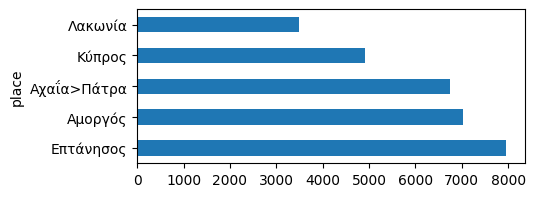

In [50]:
proverbs_sp.place.value_counts()[:5].plot.barh(figsize=(5,2));

* Visualising the places along with the number of proverbs collected in each.

In [51]:
freq_places = proverbs_sp.place.value_counts()[:20]
m = folium.Map(location=[39.0742, 21.8243], zoom_start=5)
for i in range(10):
    freq = freq_places.iloc[i]
    place = freq_places.index[i].split(">")[0]
    loc = geolocs[place]
    folium.CircleMarker((loc["lat"], loc["lon"]), 
                  radius=freq/500,
                  popup=f"{freq}",
                  color="#3186cc",
                  fill=True,
                  fill_color="#3186cc").add_to(m)
m.save('frequent_places.html')
m

* Next, we'll work with places which have 1,000 or more proverbs, allowing sampling without class imbalance issues.

In [52]:
group_level = "area"
placed = proverbs_sp.groupby(group_level)
placed_pd = pd.DataFrame({"text": placed.text.apply(list)})
placed_pd["length"] = placed_pd.text.apply(len)
print(f"Out of the {placed_pd.shape[0]} places, {placed_pd[placed_pd.length>1000].shape[0]} own 1000 proverbs or more.")

Out of the 129 places, 23 own 1000 proverbs or more.


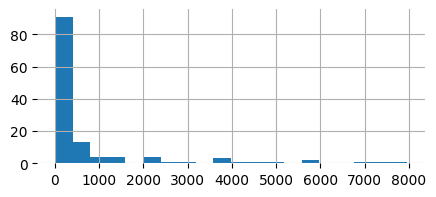

In [53]:
placed_pd.length.hist(bins=20, figsize=(5,2));
sns.despine(left=True, bottom=True)

* The proverbs from places reported at least 1,000 times are more than 80,000.

In [54]:
common_places = placed_pd[placed_pd.length>=1000].index
# filtering texts found on these places
common_sayings = proverbs_sp[proverbs_sp[group_level].isin(common_places)]
print(f"Found {common_sayings.shape[0]} proverbs from {len(common_places)} places")

Found 80893 proverbs from 23 places


* Removing proverbs with unknown (invalid?) characters.

In [55]:
stopchars = {'$', '*', '+', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'G', 'H', 'I', 'N', 'O', 'P', 'S', 'T', 'W', '[', ']', 'a','b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'y', 'z', 'ä', '\ufeff'}
common_sayings_norm = common_sayings[~common_sayings.text.apply(lambda x: len(set(x).intersection(stopchars))>0)]

* Creating a location-balanced corpus.

In [56]:
balanced_corpus = pd.concat([common_sayings_norm[common_sayings_norm.area==a].sample(500) for a in common_places])
balanced_corpus.shape

(11500, 7)

## Location-based TFILF
* For each place, we compute character n-gram frequencies (TF).
* Terms infrequent across locations (location > document) are more important (ILF). 

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [38]:
long_texts = [" \n ".join(balanced_corpus[balanced_corpus.area==a].text.values) for a in common_places]
vect = TfidfVectorizer(ngram_range=(1,1), analyzer="word", max_df=0.5, min_df=1, lowercase=True)
X = vect.fit_transform(long_texts)

In [39]:
# computing the TFIDF per place
geotfidf = pd.DataFrame(columns = common_places, index=vect.get_feature_names_out())
for i, a in enumerate(common_places):
    geotfidf[a] = np.array(X[i].sum(0))[0]

* Sorting the frequencies per place, gives characteristic n-grams; i.e., frequent locally yet infrequent globally.

In [40]:
geotfidf.sort_values(by="Κύπρος", ascending=False).head(3)

area,Ήπειρος,Αιτωλία,Αμοργός,Ανατολική Θράκη,Αρκαδία,Αχαΐα,Επτάνησος,Εύβοια,Θεσπρωτία,Θράκη,...,Κρήτη,Κύπρος,Λέσβος,Λακωνία,Μακεδονία,Μικρά Ασία,Νάξος,Πόντος,Ρόδος,Σκύρος
τζ,0.0,0.0,0.0,0.0,0.0,0.0,0.015971,0.0,0.0,0.0,...,0.0,0.661621,0.0,0.0,0.0,0.0,0.015777,0.0,0.0,0.0
τζαι,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.360815,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
τζαί,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.343215,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


* Computing a lexicon with the terms with the highest TFIDF value per area

In [41]:
area_ngrams = {a:list(geotfidf.sort_values(by=a, ascending=False)[a].head(3).index) for a in common_places}
area_ngrams

{'Ήπειρος': ['τουν', 'ου', 'τούν'],
 'Αιτωλία': ['ου', 'τουν', 'είνι'],
 'Αμοργός': ['λωλός', 'γυρεύγει', 'μηδέ'],
 'Ανατολική Θράκη': ['πάγη', 'γίνουνται', 'βάσανα'],
 'Αρκαδία': ['πόδια', 'ρε', 'θες'],
 'Αχαΐα': ['ήρθε', 'ήναι', 'στους'],
 'Επτάνησος': ['ναν', 'τσου', 'τονε'],
 'Εύβοια': ['τσαί', 'τσαι', 'σι'],
 'Θεσπρωτία': ['δρόμο', 'αλλά', 'γομάρι'],
 'Θράκη': ['πε', 'δι', 'τς'],
 'Ιωάννινα': ['μι', 'τουν', 'ου'],
 'Κάρπαθος': ['τσαί', 'τσαι', 'μήε'],
 'Κεφαλληνία': ['τσου', 'τση', 'ναν'],
 'Κρήτη': ['ντου', 'οντέ', 'απου'],
 'Κύπρος': ['τζ', 'τζαι', 'τζαί'],
 'Λέσβος': ['τσι', 'τουν', 'είνι'],
 'Λακωνία': ['γίνου', 'μαλώνουν', 'δική'],
 'Μακεδονία': ['τουν', 'ου', 'μι'],
 'Μικρά Ασία': ['κη', 'τουν', 'κή'],
 'Νάξος': ['τζη', 'ια', 'ίνεται'],
 'Πόντος': ['σο', 'ατ', 'σην'],
 'Ρόδος': ['λωλλός', 'ηύραν', 'γρηά'],
 'Σκύρος': ['τσαί', 'τσαι', 'έναι']}

* Locating the important terms per location on a map (clickable pins)

In [42]:
m = folium.Map(location=[39.0742, 21.8243], zoom_start=5)
for a in area_ngrams:
    ngrams = ", ".join(area_ngrams[a])
    loc = geolocs[a]
    folium.Circle([loc["lat"], loc["lon"]], 20000, fill=True).add_child(folium.Popup(ngrams)).add_to(m)
m.save('frequent_ngrams.html')
m

In [43]:
geotfidf.to_csv("data/geotfidf.csv", index=False)
pd.DataFrame(area_ngrams)

,Ήπειρος,Αιτωλία,Αμοργός,Ανατολική Θράκη,Αρκαδία,Αχαΐα,Επτάνησος,Εύβοια,Θεσπρωτία,Θράκη,...,Κρήτη,Κύπρος,Λέσβος,Λακωνία,Μακεδονία,Μικρά Ασία,Νάξος,Πόντος,Ρόδος,Σκύρος
0,τουν,ου,λωλός,πάγη,πόδια,ήρθε,ναν,τσαί,δρόμο,πε,...,ντου,τζ,τσι,γίνου,τουν,κη,τζη,σο,λωλλός,τσαί
1,ου,τουν,γυρεύγει,γίνουνται,ρε,ήναι,τσου,τσαι,αλλά,δι,...,οντέ,τζαι,τουν,μαλώνουν,ου,τουν,ια,ατ,ηύραν,τσαι
2,τούν,είνι,μηδέ,βάσανα,θες,στους,τονε,σι,γομάρι,τς,...,απου,τζαί,είνι,δική,μι,κή,ίνεται,σην,γρηά,έναι


In [44]:
# using English names and printing a latex table
loc_name = {'Ήπειρος':'Epirus', 'Αιτωλία':'Etolia', 'Αμοργός':'Amorgos', 'Ανατολική Θράκη': 'East Thrace',
            'Αρκαδία':'Arcadia', 'Αχαΐα':'Achaia', 'Επτάνησος':'Eptanisos', 'Εύβοια':'Eyvoia', 'Θεσπρωτία':'Thesprotia', 
             'Θράκη': 'Thrace', 'Ιωάννινα':'Ioannina', 'Κάρπαθος':'Karpathos', 'Κεφαλληνία':'Kefalinia', 'Κρήτη':'Crete',
            'Κύπρος':'Cyprus', 'Λέσβος':'Lesvos', 'Λακωνία':'Laconia', 'Μακεδονία':'Macedonia', 'Μικρά Ασία':'Asia Minor',
            'Νάξος':'Naxos', 'Πόντος':'Pontos', 'Ρόδος':'Rodos', 'Σκύρος':'Skyros'}
area_ngrams = {a:list(geotfidf.sort_values(by=a, ascending=False)[a].head(3).index) for a in common_places}
for area in area_ngrams:
    print(f'{loc_name[area]} & {" & ".join(area_ngrams[area])} \\\\')

Epirus & τουν & ου & τούν \\
Etolia & ου & τουν & είνι \\
Amorgos & λωλός & γυρεύγει & μηδέ \\
East Thrace & πάγη & γίνουνται & βάσανα \\
Arcadia & πόδια & ρε & θες \\
Achaia & ήρθε & ήναι & στους \\
Eptanisos & ναν & τσου & τονε \\
Eyvoia & τσαί & τσαι & σι \\
Thesprotia & δρόμο & αλλά & γομάρι \\
Thrace & πε & δι & τς \\
Ioannina & μι & τουν & ου \\
Karpathos & τσαί & τσαι & μήε \\
Kefalinia & τσου & τση & ναν \\
Crete & ντου & οντέ & απου \\
Cyprus & τζ & τζαι & τζαί \\
Lesvos & τσι & τουν & είνι \\
Laconia & γίνου & μαλώνουν & δική \\
Macedonia & τουν & ου & μι \\
Asia Minor & κη & τουν & κή \\
Naxos & τζη & ια & ίνεται \\
Pontos & σο & ατ & σην \\
Rodos & λωλλός & ηύραν & γρηά \\
Skyros & τσαί & τσαι & έναι \\


In [45]:
balanced_corpus.to_csv('balanced_corpus.csv', index=False)